# Predict Housing Type using K-Nearest Neighbors 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar

## Goal 
Use the k-nearest neighbors algorithm to predict the housing type of homes in Melbourne. Also decide the best k-value that yields the highest accuracy and whether to implement weighted or majority voting. 

## Data Loading

In [3]:
df_melb = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/81b236aecee57f6cf65e60afd865d2bb/raw/56ddb53aa90c26ab1bdbfd0b8d8229c8d08ce45a/melb_data_train.csv')

## Fix a column of data to be numeric

The column "Date" is an object, so we need to convert it to seconds since epoch to be useful. 

In [4]:
# normalize date accepts the date string as shown in the df_melb 'Date' column,
# and returns a data in a standarized format
def standardize_date(d):
    split = d.split('/')
    dateStr = split[0] + ' ' + split[1] + ' '
    if len(split[2]) == 2:
        dateStr += split[2]
    else:
        yearSplit = list(split[2])
        dateStr += yearSplit[2]
        dateStr += yearSplit[3]
    return dateStr

In [5]:
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x)) 

df_melb['unixtime'] = df_melb['Date'].apply(lambda x: int(time.mktime(time.strptime(x, "%d %m %y"))))
df_melb = df_melb.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_melb['unixtime'].min(),df_melb['unixtime'].max()))

The min unixtime is 1454565600 and the max unixtime is 1506142800


## Use Imputation to fill in missing values
- Use the mean of each column to fill in missing values. 
- Save the mean of each column in a dictionary, dict_imputation, whose key is the attribute column name, so we can apply the same imputation to the test set later.

In [6]:
target_col = 'Type'

In [7]:
dict_imputation = dict()
for col in df_melb.columns:
    if col != target_col:
        dict_imputation[col] = df_melb[col].mean()
df_melb.fillna(value=dict_imputation, inplace=True)

In [8]:
dict_imputation

{'Rooms': 2.71,
 'Price': 932558.7,
 'Distance': 10.5246,
 'Postcode': 3113.122,
 'Bathroom': 1.44,
 'Car': 1.503006012024048,
 'Landsize': 638.91,
 'BuildingArea': 121.78320000000001,
 'YearBuilt': 1970.9417475728155,
 'unixtime': 1485197193.6}

In [9]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,h,399000,8.7,3032,1,1.0,904,53.0000,1985.000000,1462597200
1,3,h,1241000,13.9,3165,1,1.0,643,121.7832,1970.941748,1472360400
2,2,u,550000,3.0,3067,1,1.0,1521,121.7832,1970.941748,1499490000
3,3,u,691000,8.4,3072,1,1.0,170,121.7832,1970.941748,1498280400
4,2,u,657500,4.6,3122,1,1.0,728,73.0000,1965.000000,1479535200


## Normalize all the attributes to be between [0,1]

In [10]:
dict_normalize = dict()
for col in df_melb.columns:
    if col != target_col:
        colSeries = df_melb[col]
        colMin = colSeries.min()
        colMax = colSeries.max()
        
        dict_normalize[col] = (colMin, colMax)
        
        df_melb[col] = (colSeries - colMin) / (colMax - colMin)

In [11]:
dict_normalize

{'Rooms': (1, 6),
 'Price': (291000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3002, 3810),
 'Bathroom': (0, 4),
 'Car': (0.0, 4.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 475.0),
 'YearBuilt': (1890.0, 2015.0),
 'unixtime': (1454565600, 1506142800)}

In [12]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.2,h,0.022838,0.171674,0.037129,0.25,0.25,0.021836,0.111579,0.760000,0.155720
1,0.4,h,0.200888,0.283262,0.201733,0.25,0.25,0.015531,0.256386,0.647534,0.345013
2,0.2,u,0.054768,0.049356,0.080446,0.25,0.25,0.036739,0.256386,0.647534,0.871013
3,0.4,u,0.084584,0.165236,0.086634,0.25,0.25,0.004106,0.256386,0.647534,0.847561
4,0.2,u,0.077501,0.083691,0.148515,0.25,0.25,0.017585,0.153684,0.600000,0.484121


## Load in the Test data and prepare it for classification

In [13]:
# load data 
df_test = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c3d53303cebbd986b166591d19254bac/raw/94eb3b2d500d5f7bbc0441a8419cd855349d5d8e/melb_data_test.csv')

In [14]:
# fix date
df_test['Date'] = df_test['Date'].apply(lambda x : standardize_date(x))
df_test['unixtime'] = df_test['Date'].apply(lambda x: int(time.mktime(time.strptime(x, "%d %m %y"))))
df_test = df_test.drop(columns='Date')
print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_test['unixtime'].min(),df_test['unixtime'].max()))

The min unixtime is 1454565600 and the max unixtime is 1506142800


In [15]:
# imputation using above dictionary 
df_test.fillna(value=dict_imputation, inplace=True)
df_test.head() 

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,3,h,1116000,17.9,3192,1,2.0,610,121.7832,1970.941748,1498885200
1,3,h,2030000,11.2,3186,2,2.0,366,121.7832,1970.941748,1472360400
2,3,h,1480000,10.7,3187,2,2.0,697,143.0000,1925.000000,1478498400
3,3,u,1203500,12.3,3166,2,2.0,311,127.0000,2000.000000,1495861200
4,3,h,540000,14.7,3030,2,2.0,353,135.0000,2011.000000,1504414800


In [16]:
# scaling using dictionary from above
for col in df_test.columns:
    if col != target_col:
        mini = dict_normalize[col][0]
        maxi = dict_normalize[col][1]
        df_test[col] = (df_test[col] - mini) / (maxi - mini)
df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.4,h,0.174455,0.369099,0.235149,0.25,0.5,0.014734,0.256386,0.647534,0.859287
1,0.4,h,0.367731,0.225322,0.227723,0.50,0.5,0.008841,0.256386,0.647534,0.345013
2,0.4,h,0.251427,0.214592,0.228960,0.50,0.5,0.016836,0.301053,0.280000,0.464019
3,0.4,u,0.192958,0.248927,0.202970,0.50,0.5,0.007512,0.267368,0.880000,0.800656
4,0.4,h,0.052654,0.300429,0.034653,0.50,0.5,0.008527,0.284211,0.968000,0.966497


## Write the kNN classifier function

The function knn_class, takes five parameters, the training dataframe (that includes the target column), the hyper parameter k, the name of the target column, a single observation row of the test dataframe, and a boolean use_weighted_vote.  

When use_weighted_vote is set to true, weighted voting is implemented, otherwise majority voting is used. 

The function returns the predicted target classification for that observation. 

In [17]:
def knn_class(df_train, k, target_col, observation, use_weighted_vote ):
    df_X_train = df_train.drop(columns=target_col)
    observation_X = observation.drop(target_col)
    y = np.array(observation_X)
    
    dists = []
    for idx, row in df_X_train.iterrows():
        X = np.array(row)
        dists += [np.linalg.norm(X-y)]
    
    nearest_idxs = np.argsort(dists)[0:k]
    nearest_labels = df_train[target_col][nearest_idxs]
    predMaj = nearest_labels.mode().tolist()[0]
    
    if use_weighted_vote is True:
        weights = []
        for idx in nearest_idxs:
            weights.append(1 / dists[idx])
        weighted_nearest_labels = pd.concat([nearest_labels.reset_index(drop=True), pd.Series(weights)], axis=1)
        weighted_freq = weighted_nearest_labels.groupby('Type').sum()
        predWeight = list(weighted_freq.idxmax())[0]
        return predWeight
    
    return predMaj

## Compute the accuracy using different k values

For each value of k in the set {1,3,13,25,50,100}, calculate the class prediction for each oberservation in the test set, and the overall accuracy of the classifier. Plot the accuracy as a function of k when use_weighted_vote is True and when use_weighted_vote is False.

In [18]:
poss_k = [1,3,13,25,50,100] # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

total = len(df_test)
k_idx = 0
for k in poss_k:
    correctPredMaj = 0
    correctPredWeight = 0
    
    for idx, row in df_test.iterrows():
        predictionMaj = knn_class(df_melb, k, target_col, row, False)
        predictionWeight = knn_class(df_melb, k, target_col, row, True)
        
        if predictionMaj == row[target_col]:
            correctPredMaj += 1
        if predictionWeight == row[target_col]:
            correctPredWeight += 1
    
    acc_k_majority[k_idx] = (correctPredMaj / total)
    acc_k_weighted[k_idx] = (correctPredWeight / total)
    
    k_idx += 1

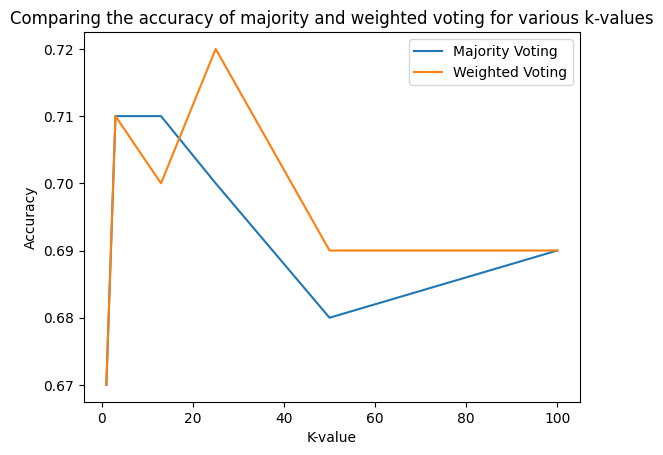

In [19]:
plt.plot(poss_k, acc_k_majority, label='Majority Voting');\
plt.plot(poss_k, acc_k_weighted, label='Weighted Voting')
plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.title('Comparing the accuracy of majority and weighted voting for various k-values')
plt.legend()
plt.show()

## Conclusion
- I would chose k = 25 and a weighted voting scheme because these parameters yield the highest accuracy of predictions, as seen by the orange peak in the plot. 
- Weighted voting is generally more accurate because it takes into account the distance from each point to the target variable, so it makes sense that the weighted voting accuracies would be higher than those of the majority voting. 
- Increasing the k-value has pros and cons. While increasing k does make the prediction more robust to noise, it may cause some trends in the data to be overlooked. We can tell from the downward trend of the plot after k=25 that considering more points actually misinforms the prediction, so ideally, 25 neighbors should be considered. 